**Problem 2.2: Extra Credit**

Attributions: Elena did parts (a) and (b).

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import re

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


**a)** First, we are asked to generate an array (in our case, a `DataFrame`) containing the total number of sleep minutes during the third night of the experiment of each wild type fish. We define a function, `rest_total`, which is similar to the function we wrote in 2.1 for sleep latency, except that here we find the number of minutes that are `True` for rest, rather than the index of the first rest minute. After restricting our `DataFrame` to wild-type fish on the third night, we group by `'fish'` and apply the `rest_total` function to generate the `DataFrame` we will work with in subsequent sections.

In [4]:
# Load the DataFrame from Tutorial 2a.
df = pd.read_csv('130315_1_minute_intervals.csv')

def rest_total (s, wake_threshold):
    """
    Given activity series s, returns the total number of rest minutes.
    """
    # Get Boolean for rest
    rest = (s < wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(rest) is pd.core.series.Series:
        rest = rest.values
    
    # Find the index of the first minute with no detectable activity
    rest_tot = np.sum(rest)
        
    return rest_tot

# Get indices for wild type fish on third night
inds = (~df.light) & (df.day==2) & (df.genotype=='wt')

# Group the DataFrame by fish
df_gb = df[inds].groupby('fish')['activity']

# Calculate the total rest minutes for each fish
df_rest_tot = df_gb.apply(rest_total, wake_threshold=1e-5).reset_index()
df_rest_tot = df_rest_tot.rename(columns={'activity':'total rest'})
df_rest_tot

,fish,total rest
0,FISH14,200
1,FISH18,190
2,FISH2,200
3,FISH24,249
4,FISH28,232
5,FISH29,319
6,FISH30,104
7,FISH54,93
8,FISH58,233
9,FISH61,287


**b)** In order to compute and plot the posterior probability $P(\mu,\sigma \mid D,I)$, we first load the functions provided in the homework assignment.

In [3]:
def log_prior(mu, sigma, mu_range):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < mu_range[0] or mu > mu_range[1]:
        return -np.inf
    else:
        return -np.log(sigma)


def log_likelihood(data, mu, sigma):
    """
    Log of the unnormalized likelihood for a single mu and sigma 
    for Gaussian distributed data.
    """
    return -((data - mu)**2).sum() / (2 * sigma**2) - n * np.log(sigma)


def log_posterior(log_likelihood_fun, log_prior_fun, data, mu, sigma, 
                  mu_range):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i, sig in enumerate(sigma):
        for j, m in enumerate(mu):
            log_post[i, j] = log_likelihood_fun(data, m, sig) \
                                + log_prior_fun(m, sig, mu_range)

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

To get an idea of what ranges to sample for $\mu$ and $\sigma$, we calculated the mean and standard deviation of the number of rest minutes using `Pandas`. 

In [23]:
df_mean = df_rest_tot.mean()
df_std = df_rest_tot.std()

print('mean = ' + str(df_mean['total rest']))
print('std = ' + str(df_std['total rest']))

mean = 197.647058824
std = 77.8660237013


We then played around with a few ranges for $\mu$ and $\sigma$ centered around the values calculated above, until we found ranges that gave a reasonable-looking posterior probability plot. 

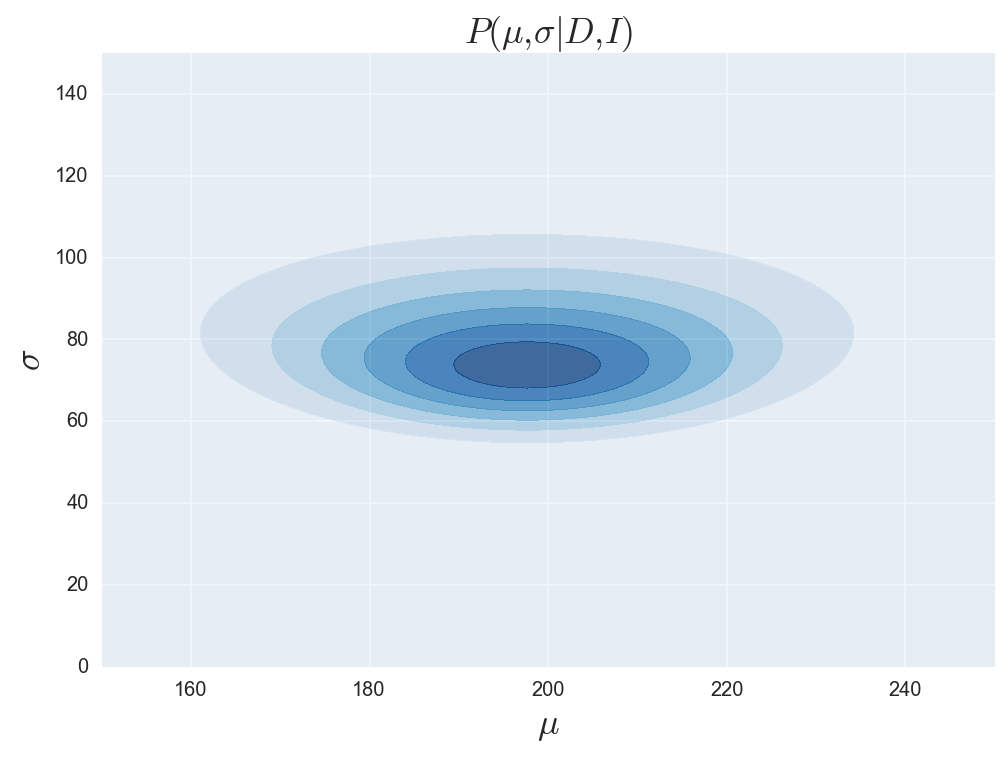

In [24]:
data = np.array(df_rest_tot['total rest'])

# Number of data points, for convenience
n = len(data)

# Ranges to sample parameters
mu = np.linspace(150.0, 250.0, 500)
sigma = np.linspace(0.1, 150.0, 500)

# Assume mu uniform on 100 < mu < 250
mu_range = (100, 250)

# Compute the posterior
log_post = log_posterior(log_likelihood, log_prior, data, mu, sigma, mu_range)

# Use contourf with Blues colormap.
plt.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$')

Finally, we used the rough calculation method given in the assignment to compute the most probable values of $\mu$ and $\sigma$.

In [14]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 197.695
most probable sigma = 73.398
